# DICE 2013R (Vanilla flavour)

This notebook compares DICE.jl to the `DICE2013R_100413_vanilla.gms` GAMS file.

Differences in the output do exist, since we use the open source **Ipopt** NLP solver instead of the commercial **CONOPT** solver.
All values and functions that can be compared have been checked and validated to match 1:1 to the GAMS implementation.
Interestingly enough, the commercial solver under-performs compared to the open source one, yielding a maximum utility of 2689.1762 (CONOPT) compared to 2690.2447128731565 (IPOPT) for the optimal control scenario.

In [1]:
# For Solving #
using DICE;

# For Plotting #
using Plots;

# For Comparing with GAMS data
using DataFrames;
using CSV;

## Base Price Scenario

The Vanilla flavour of the 2013R version has a base carbon price and an optimal carbon price scenario.

If you are interested in just the preset scenarios there is no reason to generate a configuration struct by calling `options(v2013R())`, since this is called internally and altered as needed if necessary.

Calling the solve function directly is all that's needed to obtain all results.

*Note:* we call `v2013R()`, which is sytactic sugar for `v2013R(Vanilla)`.

In [2]:
base = solve(BasePrice, v2013R())

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3954
Number of nonzeros in inequality constraint Jacobian.:      177
Number of nonzeros in Lagrangian Hessian.............:      957

Total number of variables............................:     1561
                     variables with only lower bounds:      540
                variables with lower and upper bounds:      180
                     variables with only upper bounds:      120
Total number of equality constraints.................:     1391
Total number of inequality constraints...............:       59
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       59

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

Base (current policy) carbon price scenario using v2013R (Vanilla flavour).
A JuMP Model
Maximization problem with:
Variables: 1561
Objective function type: JuMP.VariableRef
`JuMP.VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 720 constraints
`JuMP.VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 300 constraints
`JuMP.GenericAffExpr{Float64,JuMP.VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 671 constraints
`JuMP.GenericQuadExpr{Float64,JuMP.VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 240 constraints
Nonlinear: 539 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: SolverName() attribute not implemented by the optimizer.
Names registered in the model: C, CCA, CEMUTOTPER, CPC, CPRICE, DAMAGES, E, Eind, FORC, I, K, MCABATE, Mᵤₚ, Mₐₜ, Mₗₒ, PERIODU, RI, S, Tₐₜ, Tₗₒ, UTILITY, Y, YGROSS, YNET, Λ, Ω, μ

The variable `base` is now a complete solution of type `DICENarrative`.

It contains all of the model parameters and information, as well as usable results.

In [11]:
fieldnames(typeof(base))

(:constants, :parameters, :model, :scenario, :version, :variables, :equations, :results)

Whilst the `results` are fairly comprehensive, you may wish to look at specific values of the model directly. Since most of these are in their raw state you will need to `import JuMP` to read them correctly.

---

Word of warning: if you `print(base.model)` in this notebook you're gonna have a bad time.
It's apparently too big to print or something.
The thread just locks up/spools forever.

There's a *limit output* notebook extension which can truncate things for you.
It seems to be necessary if you want to use notebooks which have actual output.

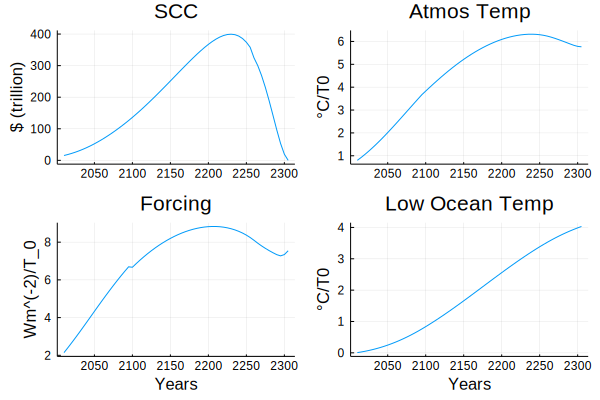

In [4]:
# Plot major outputs #
r = base.results;
a = plot(r.years,r.scc, ylabel="\$ (trillion)", title="SCC")
b = plot(r.years,r.Tₐₜ, ylabel="°C/T0", title="Atmos Temp")
c = plot(r.years,r.FORC, xlabel="Years", ylabel="Wm^(-2)/T_0", title="Forcing")
d = plot(r.years,r.Tₗₒ, xlabel="Years", ylabel="°C/T0", title="Low Ocean Temp")
plot(a,b,c,d,layout=(2,2),legend=false)

# Optimal Scenario

The optimal carbon price scenario is ran in a similar fashion.

In [5]:
opt = solve(OptimalPrice, v2013R())

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3954
Number of nonzeros in inequality constraint Jacobian.:      177
Number of nonzeros in Lagrangian Hessian.............:      957

Total number of variables............................:     1561
                     variables with only lower bounds:      540
                variables with lower and upper bounds:      180
                     variables with only upper bounds:       76
Total number of equality constraints.................:     1391
Total number of inequality constraints...............:       59
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       59

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

Optimal carbon price scenario using v2013R (Vanilla flavour).
A JuMP Model
Maximization problem with:
Variables: 1561
Objective function type: JuMP.VariableRef
`JuMP.VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 720 constraints
`JuMP.VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 300 constraints
`JuMP.GenericAffExpr{Float64,JuMP.VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 671 constraints
`JuMP.GenericQuadExpr{Float64,JuMP.VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 240 constraints
Nonlinear: 539 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: SolverName() attribute not implemented by the optimizer.
Names registered in the model: C, CCA, CEMUTOTPER, CPC, CPRICE, DAMAGES, E, Eind, FORC, I, K, MCABATE, Mᵤₚ, Mₐₜ, Mₗₒ, PERIODU, RI, S, Tₐₜ, Tₗₒ, UTILITY, Y, YGROSS, YNET, Λ, Ω, μ

## Comparision

To compare our values to the GAMS version, I've run the optimal version and output some of the more important variables. Feel free to check this yourself if you have a GAMS license and CONOPT.

In [6]:
#Load in the results of an 'optimal=true' gams run.
gams = CSV.read("Vanilla2013RResults.csv", transpose=true)
names!(gams, [:Period,:Year,:SCC,:TATM,:FORCE,:TOCEAN]);

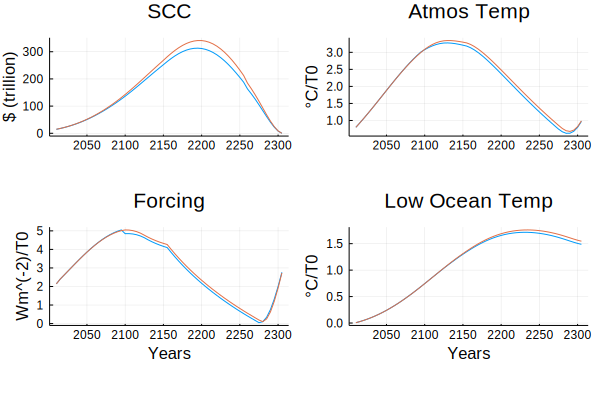

In [12]:
ro = opt.results;
a = plot(ro.years,ro.scc, ylabel="\$ (trillion)", title="SCC")
plot!(gams[!,:Year], gams[!,:SCC])
b = plot(ro.years,ro.Tₐₜ, ylabel="°C/T0", title="Atmos Temp")
plot!(gams[!,:Year],gams[!,:TATM])
c = plot(ro.years,ro.FORC, xlabel="Years", ylabel="Wm^(-2)/T0", title="Forcing")
plot!(gams[!,:Year],gams[!,:FORCE])
d = plot(ro.years,ro.Tₗₒ, xlabel="Years", ylabel="°C/T0", title="Low Ocean Temp")
plot!(gams[!,:Year],gams[!,:TOCEAN])
plot(a,b,c,d,layout=(2,2),legend=false)

It's clear from these plots that the social cost of carbon in our runs is lower overall than the same run in the GAMS solution.

# Validation

This is output cleaned up from the GAMS `lst` output file of an optimised run. 

In [8]:
vars = CSV.read("Vanilla2013RVars.csv");

Below, all parameters and variables are compared.
The only plots that differ are ones that are partially or totally dependent on a value which has been optimised.

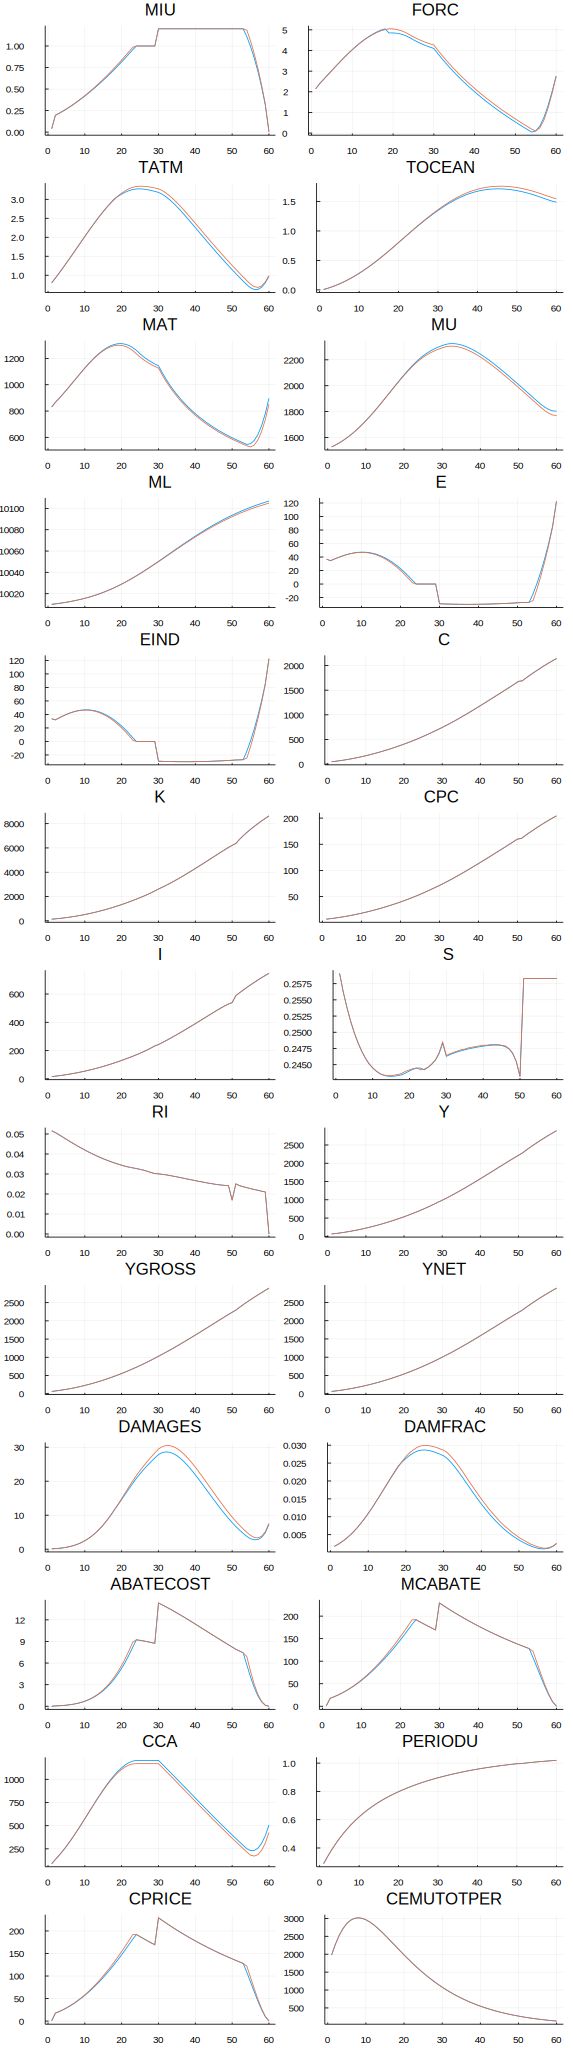

In [13]:
a = plot(ro.μ, title="MIU")
plot!(vars[!,:MIU])
b = plot(ro.FORC, title="FORC")
plot!(vars[!,:FORC])
c = plot(ro.Tₐₜ, title="TATM")
plot!(vars[!,:TATM])
d = plot(ro.Tₗₒ, title="TOCEAN")
plot!(vars[!,:TOCEAN])
e = plot(ro.Mₐₜ, title="MAT")
plot!(vars[!,:MAT])
f = plot(ro.Mᵤₚ, title="MU")
plot!(vars[!,:MU])
g = plot(ro.Mₗₒ, title="ML")
plot!(vars[!,:ML])
h = plot(ro.E, title="E")
plot!(vars[!,:E])
i = plot(ro.Eind, title="EIND")
plot!(vars[!,:EIND])
j = plot(ro.C, title="C")
plot!(vars[!,:C])
k = plot(ro.K, title="K")
plot!(vars[!,:K])
l = plot(ro.CPC, title="CPC")
plot!(vars[!,:CPC])
m = plot(ro.I, title="I")
plot!(vars[!,:I])
n = plot(ro.S, title="S")
plot!(vars[!,:S])
o = plot(ro.RI, title="RI")
plot!(vars[!,:RI])
p = plot(ro.Y, title="Y")
plot!(vars[!,:Y])
q = plot(ro.YGROSS, title="YGROSS")
plot!(vars[!,:YGROSS])
r1 = plot(ro.YNET, title="YNET")
plot!(vars[!,:YNET])
s = plot(ro.DAMAGES, title="DAMAGES")
plot!(vars[!,:DAMAGES])
t = plot(ro.Ω, title="DAMFRAC")
plot!(vars[!,:DAMFRAC])
u = plot(ro.Λ, title="ABATECOST")
plot!(vars[!,:ABATECOST])
v = plot(ro.MCABATE, title="MCABATE")
plot!(vars[!,:MCABATE])
w = plot(ro.CCA, title="CCA")
plot!(vars[!,:CCA])
x = plot(ro.PERIODU, title="PERIODU")
plot!(vars[!,:PERIODU])
y = plot(ro.co2price, title="CPRICE")
plot!(vars[!,:CPRICE])
z = plot(ro.CEMUTOTPER, title="CEMUTOTPER")
plot!(vars[!,:CEMUTOTPER])
plot(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r1,s,t,u,v,w,x,y,z,layout=(13,2),legend=false,label=["Julia" "GAMS"],size=(700,2500))

## Conclusion of Validation Comparisons

Since we're maximising for utility, we can safely say that the Ipopt solution is actually better than the Conopt one. All differences in the GAMS/Julia solution arise from small multiplicative differences.

- **CONOPT** finds `UTILITY = 2689.1762`
- **Ipopt** finds `UTILITY =`

In [10]:
opt.results.UTILITY

2690.24470168788